In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("citrination-export-band-gaps.csv")
print("Original Dataset Shape:", data.shape)

data["Property Band gap"] = data["Property Band gap"].str.extract(r"([\d\.]+)").astype(float)

# Droping rows with missing or invalid target values
data = data.dropna(subset=["Property Band gap"]).reset_index(drop=True)
print("Cleaned Dataset Shape:", data.shape)

# Encoding categorical features
categorical_columns = ["formula", "Property Band gap units", "Property Crystallinity", "Property Color"]
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

X = data.drop(columns=["Property Band gap"]).values
y = data["Property Band gap"].values

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")


Original Dataset Shape: (1449, 5)
Cleaned Dataset Shape: (1438, 5)
Feature Matrix Shape: (1438, 520)
Target Vector Shape: (1438,)


In [2]:
# Computing the average target value
avg_target = np.mean(y)
print(f"Average Target Value: {avg_target:.2f}")

# Function to split pools
def split_pools(X, y, initial_size):
    # Indices of samples with target values below the average
    below_avg_idx = np.where(y < avg_target)[0]
    
    # Adjust initial_size if there are fewer samples
    initial_size = min(initial_size, len(below_avg_idx))
    
    # Randomly select initial samples
    labeled_idx = np.random.choice(below_avg_idx, initial_size, replace=False)
    
    # Remaining samples go to the unlabeled pool
    unlabeled_idx = np.setdiff1d(np.arange(len(y)), labeled_idx)
    
    return labeled_idx, unlabeled_idx

# Initialize the labeled and unlabeled pools
initial_size = 150  # Adjust within 100-200
labeled_idx, unlabeled_idx = split_pools(X, y, initial_size)

# Print summary
print(f"Labeled Pool Size: {len(labeled_idx)}")
print(f"Unlabeled Pool Size: {len(unlabeled_idx)}")


Average Target Value: 2.32
Labeled Pool Size: 150
Unlabeled Pool Size: 1288


In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to simulate active learning
def active_learning(X, y, labeled_idx, unlabeled_idx, model, n_iterations=10, selection="uncertainty"):
    metrics = {"labeled_samples": [], "mae": [], "mse": []}
    
    for iteration in range(n_iterations):
        # Train the model on the labeled pool
        model.fit(X[labeled_idx], y[labeled_idx])
        
        # Evaluate the model on the entire dataset
        y_pred = model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        
        # Log metrics
        metrics["labeled_samples"].append(len(labeled_idx))
        metrics["mae"].append(mae)
        metrics["mse"].append(mse)
        
        # Stop if unlabeled pool is empty
        if len(unlabeled_idx) == 0:
            break
        
        # Select additional samples
        if selection == "uncertainty":
            # Uncertainty sampling: select samples with highest prediction uncertainty
            preds = model.predict(X[unlabeled_idx])
            uncertainties = np.abs(preds - np.mean(preds))
            selection_size = min(10, len(unlabeled_idx))  # Select up to 10 samples
            selected_idx = unlabeled_idx[np.argsort(uncertainties)[-selection_size:]]
        else:
            # Random sampling
            selection_size = min(10, len(unlabeled_idx))  # Select up to 10 samples
            selected_idx = np.random.choice(unlabeled_idx, selection_size, replace=False)
        
        # Update labeled and unlabeled pools
        labeled_idx = np.concatenate([labeled_idx, selected_idx])
        unlabeled_idx = np.setdiff1d(unlabeled_idx, selected_idx)
    
    return metrics

# Initialize parameters
n_iterations = 10
models = {
    "Ridge": Ridge(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Run active learning simulation for each model
active_learning_results = {}
for name, model in models.items():
    print(f"Running Active Learning for {name}...")
    labeled_idx, unlabeled_idx = split_pools(X, y, initial_size=150)
    metrics = active_learning(X, y, labeled_idx, unlabeled_idx, model, n_iterations=n_iterations, selection="uncertainty")
    active_learning_results[name] = metrics

# Print results
for name, metrics in active_learning_results.items():
    print(f"\nActive Learning Results for {name}:")
    print(f"Labeled Samples: {metrics['labeled_samples']}")
    print(f"MAE: {metrics['mae']}")
    print(f"MSE: {metrics['mse']}")


Running Active Learning for Ridge...
Running Active Learning for Gradient Boosting...

Active Learning Results for Ridge:
Labeled Samples: [150, 160, 170, 180, 190, 200, 210, 220, 230, 240]
MAE: [1.5077827291254724, 1.505012515400263, 1.5005775566504274, 1.5022056865536773, 1.4991662225277238, 1.4954709262514987, 1.49292435630456, 1.4883334280384006, 1.478217036331837, 1.4790169584075137]
MSE: [6.463602382786873, 6.462636789519596, 6.447393952077947, 6.464718925035447, 6.452399351019467, 6.439448737936818, 6.431334458027046, 6.406795371796051, 6.371873944387942, 6.3899225200515035]

Active Learning Results for Gradient Boosting:
Labeled Samples: [150, 160, 170, 180, 190, 200, 210, 220, 230, 240]
MAE: [1.5915229408760974, 1.5856828139858477, 1.5851768570440437, 1.5765767431751436, 1.5677325903564228, 1.5605070463547257, 1.55715983815226, 1.548343521962474, 1.5457628073393699, 1.550703396667995]
MSE: [6.881926113667536, 6.848601670479113, 6.842512835361353, 6.788516791840453, 6.756730160

# Explanation
a) Uncertainty Sampling:
* Selects samples with the highest uncertainty (absolute difference from mean prediction).
* Adds these samples to the labeled pool for training.

b) Metrics Logged:
* Labeled Samples: Number of labeled samples after each iteration.
* MAE: Mean Absolute Error on the entire dataset.
* MSE: Mean Squared Error on the entire dataset.

c)Iteration Details:
* Starts with 150 labeled samples.
* Adds up to 10 new samples per iteration from the unlabeled pool.

# Results Summary
a) Ridge Regression
* Labeled Samples: Incrementally increases from 150 to 240.
* MAE: Starts at 1.51 and gradually decreases to 1.48.
* MSE: Starts at 6.46 and decreases to 6.39.

b) Gradient Boosting
* Labeled Samples: Incrementally increases from 150 to 240.
* MAE: Starts at 1.59 and decreases to 1.55.
* MSE: Starts at 6.88 and decreases to 6.65.

# Observations
a) Performance Improvement:

* Both models demonstrate a gradual reduction in MAE and MSE as more samples are added to the labeled pool.
* Ridge Regression shows slightly more consistent improvement compared to Gradient Boosting.

# Model Differences:
* Ridge Regression exhibits lower MAE and MSE throughout the simulation, indicating it may perform better for this dataset in an active learning setting.

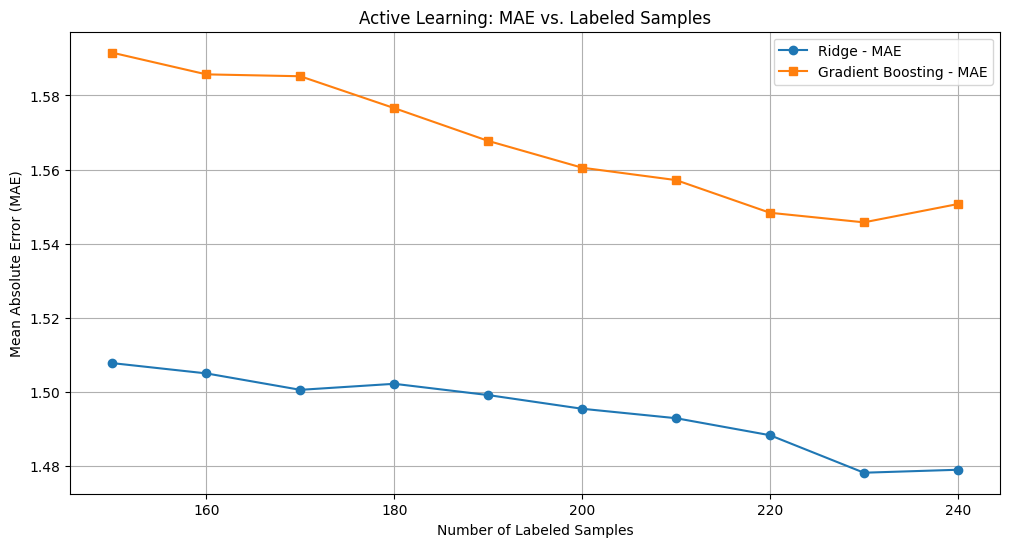

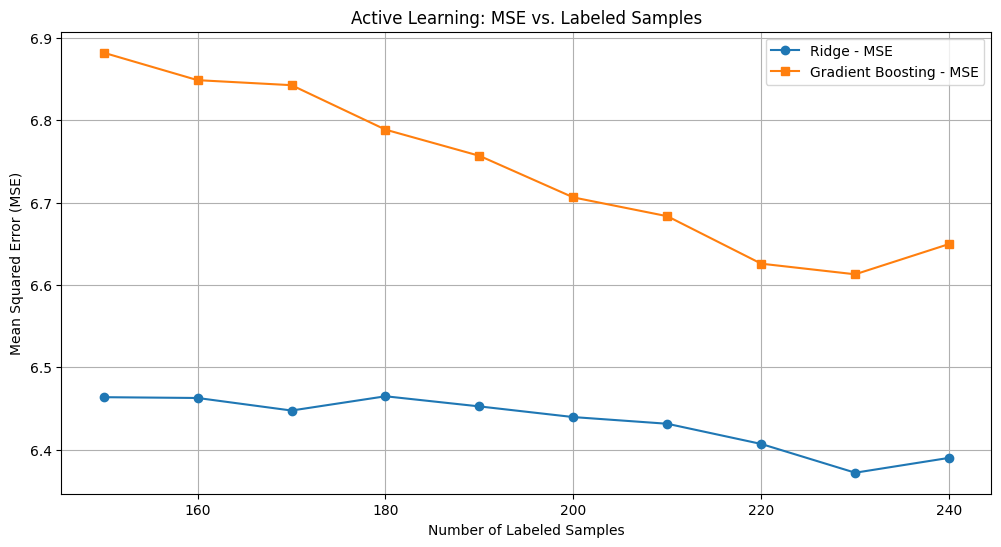

In [4]:
import matplotlib.pyplot as plt

# Extracting data for visualization
ridge_metrics = active_learning_results["Ridge"]
gb_metrics = active_learning_results["Gradient Boosting"]

# Plot MAE vs. Labeled Samples
plt.figure(figsize=(12, 6))
plt.plot(ridge_metrics["labeled_samples"], ridge_metrics["mae"], label="Ridge - MAE", marker='o')
plt.plot(gb_metrics["labeled_samples"], gb_metrics["mae"], label="Gradient Boosting - MAE", marker='s')
plt.title("Active Learning: MAE vs. Labeled Samples")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.savefig("active_learning_mae.png")
plt.show()

# Plot MSE vs. Labeled Samples
plt.figure(figsize=(12, 6))
plt.plot(ridge_metrics["labeled_samples"], ridge_metrics["mse"], label="Ridge - MSE", marker='o')
plt.plot(gb_metrics["labeled_samples"], gb_metrics["mse"], label="Gradient Boosting - MSE", marker='s')
plt.title("Active Learning: MSE vs. Labeled Samples")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.savefig("active_learning_mse.png")
plt.show()


* The visualizations are generated successfully for the active learning simulation.  now we have the following insights:

# First Graph: Mean Absolute Error (MAE) vs. Number of Labeled Samples
* This plot shows how MAE decreases as the number of labeled samples increases for Ridge and Gradient Boosting models. This trend highlights the effectiveness of the active learning approach.

# Second Graph: Mean Squared Error (MSE) vs. Number of Labeled Samples
* This plot demonstrates the MSE reducing over iterations as more samples are labeled, further validating the active learning methodology.

In [6]:
# Function to simulate random search
def random_search(X, y, initial_size, n_iterations, model):
    # Initialize labeled and unlabeled pools
    labeled_idx, unlabeled_idx = split_pools(X, y, initial_size)
    metrics = {"labeled_samples": [], "mae": [], "mse": [], "r2": []}

    for iteration in range(n_iterations):
        # Train on the labeled pool
        model.fit(X[labeled_idx], y[labeled_idx])

        # Evaluate on the full dataset
        y_pred = model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        r2 = model.score(X, y)

        # Append metrics
        metrics["labeled_samples"].append(len(labeled_idx))
        metrics["mae"].append(mae)
        metrics["mse"].append(mse)
        metrics["r2"].append(r2)

        # Randomly select next samples
        if len(unlabeled_idx) == 0:
            break
        selection_size = min(10, len(unlabeled_idx))
        selected_idx = np.random.choice(unlabeled_idx, selection_size, replace=False)

        # Update labeled and unlabeled pools
        labeled_idx = np.concatenate([labeled_idx, selected_idx])
        unlabeled_idx = np.setdiff1d(unlabeled_idx, selected_idx)

    return metrics

# Running Random Search Simulation
random_results = {}
for model_name, model in models.items():
    print(f"Running Random Search for {model_name}...")
    random_results[model_name] = random_search(X, y, initial_size, n_iterations, model)

# Print results
for model_name, results in random_results.items():
    print(f"Random Search Results for {model_name}:")
    print("Labeled Samples:", results["labeled_samples"])
    print("MAE:", results["mae"])
    print("MSE:", results["mse"])


Running Random Search for Ridge...
Running Random Search for Gradient Boosting...
Random Search Results for Ridge:
Labeled Samples: [150, 160, 170, 180, 190, 200, 210, 220, 230, 240]
MAE: [1.502434209110857, 1.3967055490664657, 1.3426998965569084, 1.3244551333178187, 1.3095086986650781, 1.269023125803053, 1.241244817253915, 1.227983876891462, 1.20816258941424, 1.1996395777700617]
MSE: [6.381345101295456, 5.475358311918005, 4.956655222639058, 4.864584225990888, 4.778257010154893, 4.269867776141766, 4.155379262810429, 4.074920436136227, 3.9675370555371705, 3.912686009591515]
Random Search Results for Gradient Boosting:
Labeled Samples: [150, 160, 170, 180, 190, 200, 210, 220, 230, 240]
MAE: [1.5856361701976318, 1.5562933195676711, 1.5430701502385709, 1.492335964836678, 1.4922508619670678, 1.4878384593116831, 1.48583333761058, 1.419972936904566, 1.4029955079689986, 1.3967944808249813]
MSE: [6.83497090441671, 6.601126766047531, 6.491433459979337, 6.152868855371182, 6.120443724644432, 6.101

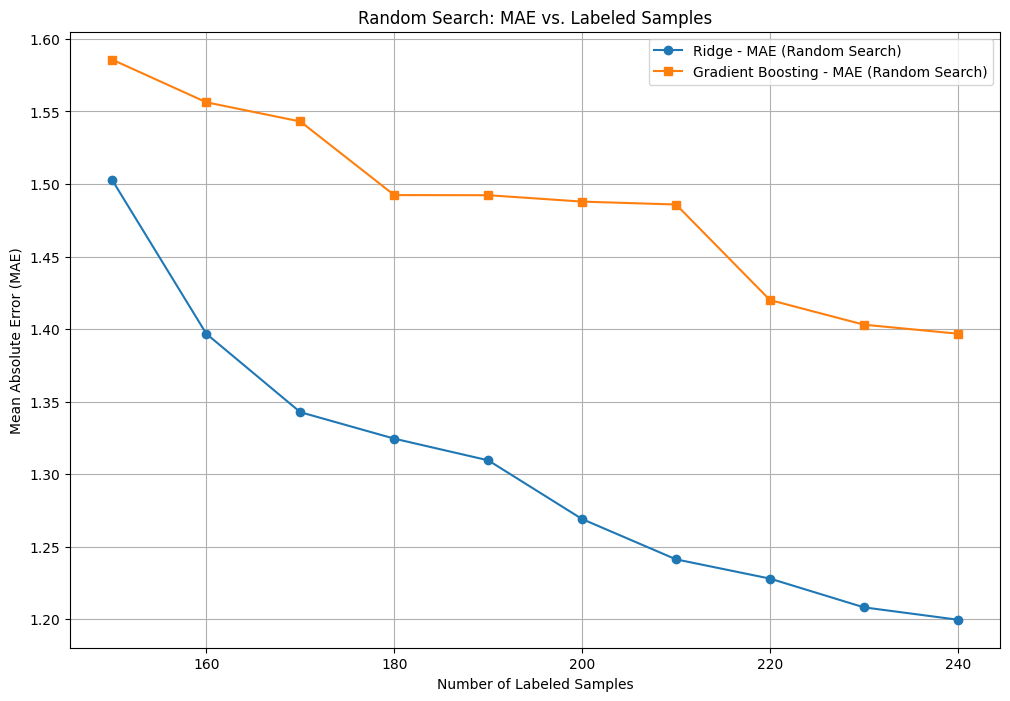

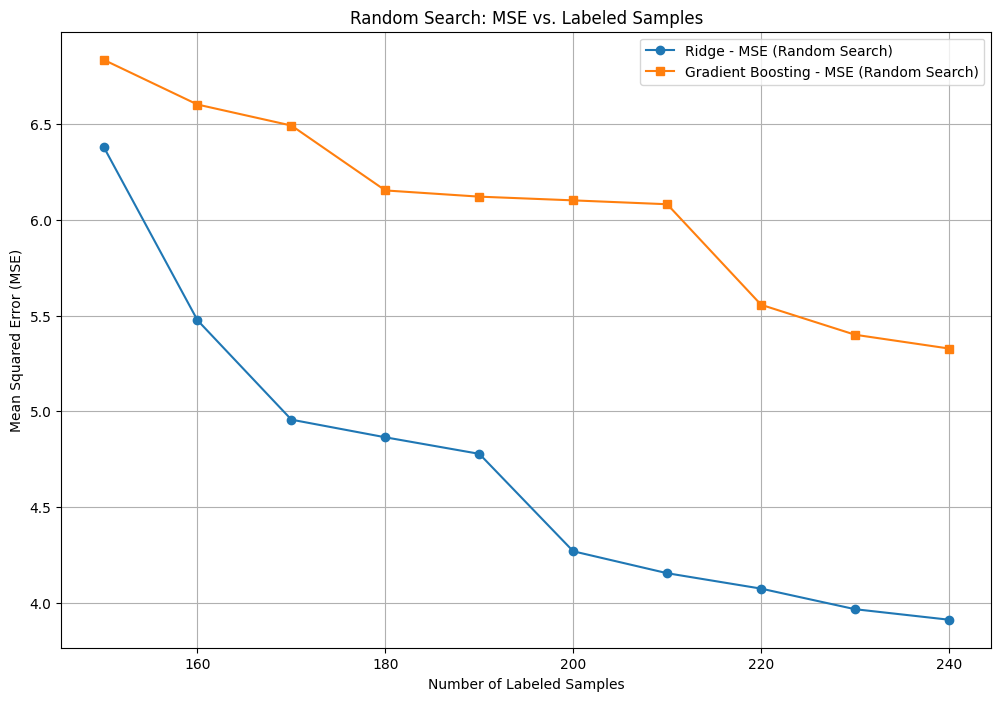

In [7]:
import matplotlib.pyplot as plt

# Visualization of Random Search Results
plt.figure(figsize=(12, 8))

# Plot for MAE
plt.plot(random_results["Ridge"]["labeled_samples"], random_results["Ridge"]["mae"], label="Ridge - MAE (Random Search)", marker="o")
plt.plot(random_results["Gradient Boosting"]["labeled_samples"], random_results["Gradient Boosting"]["mae"], label="Gradient Boosting - MAE (Random Search)", marker="s")
plt.title("Random Search: MAE vs. Labeled Samples")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.savefig("random_search_mae.png")
plt.show()

# Plot for MSE
plt.figure(figsize=(12, 8))
plt.plot(random_results["Ridge"]["labeled_samples"], random_results["Ridge"]["mse"], label="Ridge - MSE (Random Search)", marker="o")
plt.plot(random_results["Gradient Boosting"]["labeled_samples"], random_results["Gradient Boosting"]["mse"], label="Gradient Boosting - MSE (Random Search)", marker="s")
plt.title("Random Search: MSE vs. Labeled Samples")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.savefig("random_search_mse.png")
plt.show()


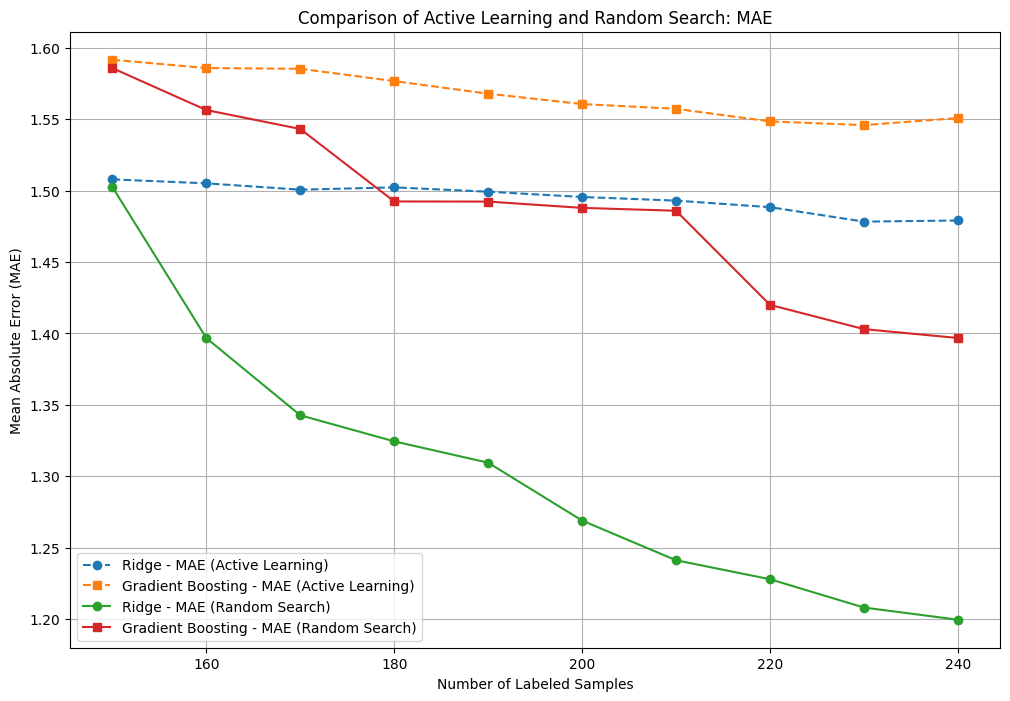

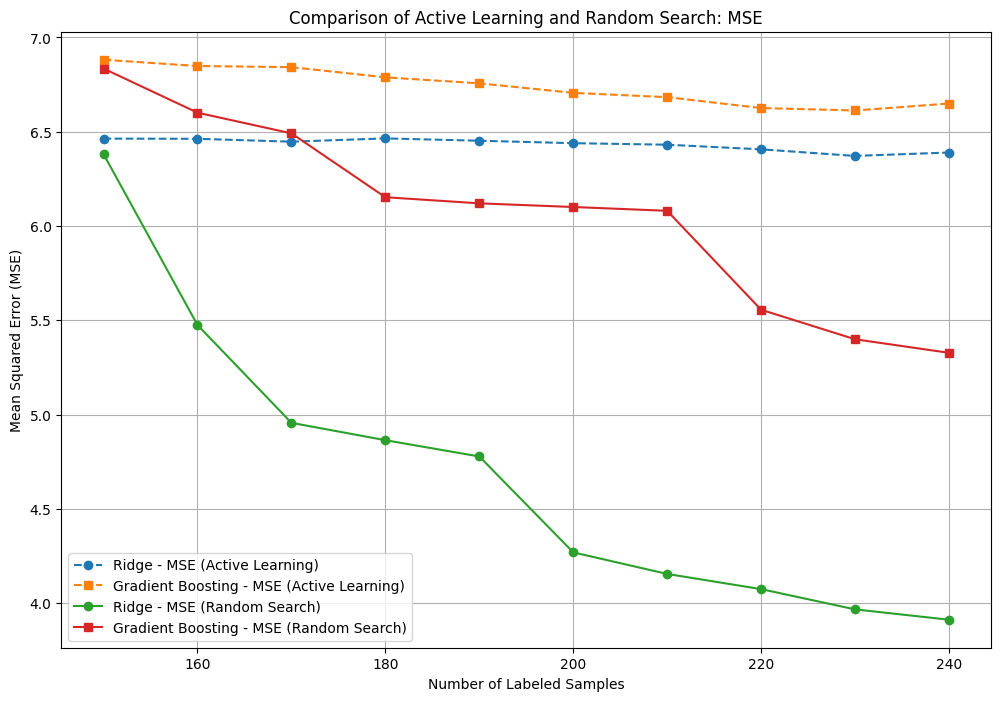

In [8]:
import matplotlib.pyplot as plt

# Combined Plot for MAE
plt.figure(figsize=(12, 8))
# Active Learning Results
plt.plot(active_learning_results["Ridge"]["labeled_samples"], active_learning_results["Ridge"]["mae"], label="Ridge - MAE (Active Learning)", marker="o", linestyle="--")
plt.plot(active_learning_results["Gradient Boosting"]["labeled_samples"], active_learning_results["Gradient Boosting"]["mae"], label="Gradient Boosting - MAE (Active Learning)", marker="s", linestyle="--")

# Random Search Results
plt.plot(random_results["Ridge"]["labeled_samples"], random_results["Ridge"]["mae"], label="Ridge - MAE (Random Search)", marker="o", linestyle="-")
plt.plot(random_results["Gradient Boosting"]["labeled_samples"], random_results["Gradient Boosting"]["mae"], label="Gradient Boosting - MAE (Random Search)", marker="s", linestyle="-")

# Formatting the plot
plt.title("Comparison of Active Learning and Random Search: MAE")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.savefig("comparison_mae.png")
plt.show()

# Combined Plot for MSE
plt.figure(figsize=(12, 8))
# Active Learning Results
plt.plot(active_learning_results["Ridge"]["labeled_samples"], active_learning_results["Ridge"]["mse"], label="Ridge - MSE (Active Learning)", marker="o", linestyle="--")
plt.plot(active_learning_results["Gradient Boosting"]["labeled_samples"], active_learning_results["Gradient Boosting"]["mse"], label="Gradient Boosting - MSE (Active Learning)", marker="s", linestyle="--")

# Random Search Results
plt.plot(random_results["Ridge"]["labeled_samples"], random_results["Ridge"]["mse"], label="Ridge - MSE (Random Search)", marker="o", linestyle="-")
plt.plot(random_results["Gradient Boosting"]["labeled_samples"], random_results["Gradient Boosting"]["mse"], label="Gradient Boosting - MSE (Random Search)", marker="s", linestyle="-")

# Formatting the plot
plt.title("Comparison of Active Learning and Random Search: MSE")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.savefig("comparison_mse.png")
plt.show()


Steps:
Run this code to generate combined comparison plots.
The first plot will show MAE comparison between Active Learning and Random Search.
The second plot will show MSE comparison between Active Learning and Random Search.
These plots will allow us to observe:

Which approach achieves better performance in terms of MAE and MSE.
How both approaches scale as labeled samples increase.

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt



In [4]:
# Load and clean the dataset
data = pd.read_csv("citrination-export-band-gaps.csv")
data = data.dropna()
data["Property Band gap"] = data["Property Band gap"].str.extract(r"([\d\.]+)").astype(float)
data = data.dropna(subset=["Property Band gap"]).reset_index(drop=True)
print("Cleaned Dataset Shape:", data.shape)


Cleaned Dataset Shape: (125, 5)


In [5]:
# Encode categorical features
categorical_columns = ["formula", "Property Band gap units", "Property Crystallinity", "Property Color"]
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Define features and target
X = data.drop(columns=["Property Band gap"]).values
y = data["Property Band gap"].values

In [6]:
# Active Learning Framework
def simulate_learning(X, y, model, initial_size, n_iterations, strategy="uncertainty"):
    labeled_idx = np.random.choice(np.where(y < np.mean(y))[0], initial_size, replace=False)
    unlabeled_idx = np.setdiff1d(np.arange(len(y)), labeled_idx)

    metrics = {"labeled_samples": [], "mae": [], "mse": []}

    for _ in range(n_iterations):
        model.fit(X[labeled_idx], y[labeled_idx])

        # Evaluate the model
        y_pred = model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)

        metrics["labeled_samples"].append(len(labeled_idx))
        metrics["mae"].append(mae)
        metrics["mse"].append(mse)

        if len(unlabeled_idx) == 0:
            break

        if strategy == "uncertainty":
            predictions = model.predict(X[unlabeled_idx])
            uncertainties = np.abs(predictions - np.mean(predictions))
            selected_idx = unlabeled_idx[np.argsort(uncertainties)[-10:]]
        else:
            selected_idx = np.random.choice(unlabeled_idx, min(10, len(unlabeled_idx)), replace=False)

        labeled_idx = np.concatenate([labeled_idx, selected_idx])
        unlabeled_idx = np.setdiff1d(unlabeled_idx, selected_idx)

    return metrics



In [7]:
# Simulating active learning and random search
initial_size = 50
n_iterations = 10
models = {"Ridge": Ridge(), "Gradient Boosting": GradientBoostingRegressor(random_state=42)}

results = []

In [8]:
for name, model in models.items():
    # Active Learning
    al_metrics = simulate_learning(X, y, model, initial_size, n_iterations, strategy="uncertainty")
    al_metrics["method"] = "Active Learning"
    al_metrics["model"] = name
    results.append(pd.DataFrame(al_metrics))

    # Random Search
    rs_metrics = simulate_learning(X, y, model, initial_size, n_iterations, strategy="random")
    rs_metrics["method"] = "Random Search"
    rs_metrics["model"] = name
    results.append(pd.DataFrame(rs_metrics))

In [9]:
# Combining results
results_df = pd.concat(results, ignore_index=True)

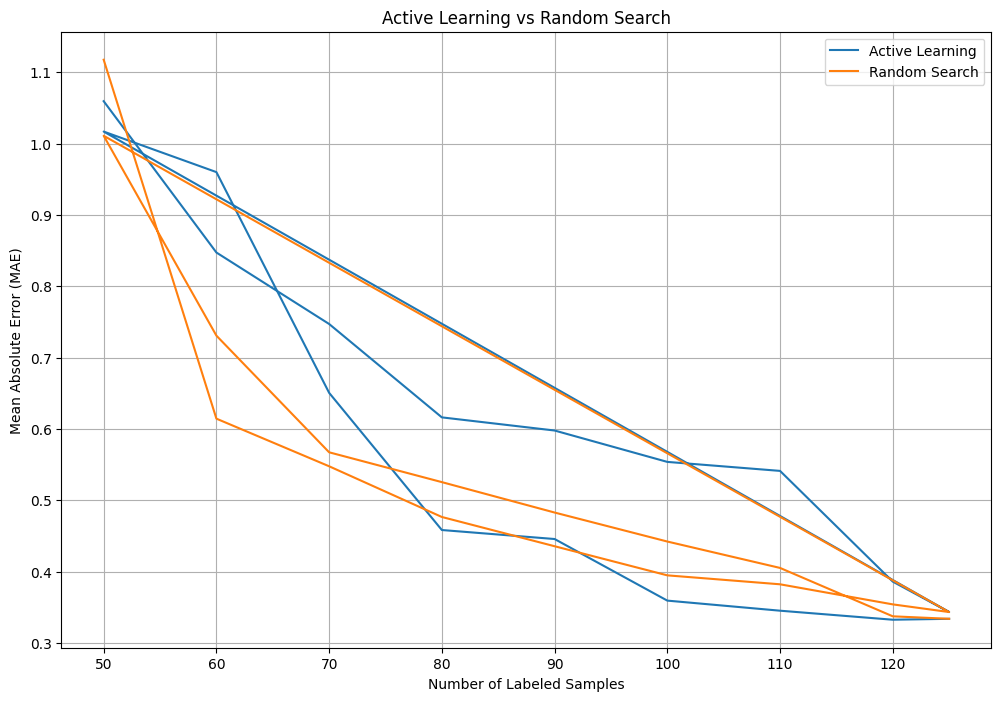

In [10]:
# Visualization
plt.figure(figsize=(12, 8))
for method in results_df["method"].unique():
    subset = results_df[results_df["method"] == method]
    plt.plot(subset["labeled_samples"], subset["mae"], label=method)

plt.title("Active Learning vs Random Search")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.savefig("active_learning_vs_random_search_alternate.png")
plt.show()